In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
import hyperopt
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from hyperopt import STATUS_OK
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import auc, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
import matplotlib.ticker as ticker
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from xgboost import XGBClassifier
for dirname, _, filenames in os.walk(r'C:\Users\USER\Desktop\LAO\資料分析\optuna'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from scipy import stats
from scipy.stats import norm, skew 
import seaborn as sns 

C:\Users\USER\Desktop\LAO\資料分析\optuna\a.ipynb
C:\Users\USER\Desktop\LAO\資料分析\optuna\english.xls
C:\Users\USER\Desktop\LAO\資料分析\optuna\E_lvr_land_A.csv
C:\Users\USER\Desktop\LAO\資料分析\optuna\KS_無調整.ipynb


In [2]:
import warnings
warnings.filterwarnings("ignore")

# 資料前處理

In [3]:
df = pd.read_csv('E_lvr_land_A.csv')

In [4]:
df = df.drop(['sign','address','non-metropolis','non-metropolis2','main use','the unit price NTD','the note','serial number','ID','main building materials'], axis=1)

In [5]:
train_data = df.dropna(subset =  ['theUseZoningorCompiles'])
train_data = train_data.dropna(subset =  ['ShiftingfloorNumber'])
train_data = train_data.dropna(subset =  ['floor'])
train_data = train_data.dropna(subset =  ['ConstructionYear'])
# train_data = train_data.dropna(subset =  ['main building materials'])

In [6]:
train_data['BerthCategory']= train_data['BerthCategory'].fillna("無")

In [7]:
labelencoder = LabelEncoder()
train_data['District'] = labelencoder.fit_transform(train_data['District'].values)
train_data['theUseZoningorCompiles'] = labelencoder.fit_transform(train_data['theUseZoningorCompiles'].values)
train_data['BuildingState'] = labelencoder.fit_transform(train_data['BuildingState'].values)
train_data['Compartment'] = labelencoder.fit_transform(train_data['Compartment'].values)
train_data['ManagementOrganization'] = labelencoder.fit_transform(train_data['ManagementOrganization'].values)
train_data['elevator'] = labelencoder.fit_transform(train_data['elevator'].values)
train_data['BerthCategory'] = labelencoder.fit_transform(train_data['BerthCategory'].values)

In [8]:
# 正則表達式用來匹配 "土地X建物Y車位Z" 格式，其中 X, Y, Z 為數字
train_data[['Land', 'Building', 'Berth']] = train_data['TransactionPenNumber'].str.extract('土地(\d+)建物(\d+)車位(\d+)')
# 轉換數據類型，因為提取出來的數據預設是字符串
train_data[['Land', 'Building', 'Berth']] = train_data[['Land', 'Building', 'Berth']].astype(int)
train_data = train_data.drop(['TransactionPenNumber'], axis=1)

In [9]:
train_data['ConstructionYear']=train_data['ConstructionYear'].astype(int)
train_data['Year'] = train_data['ConstructionYear'].apply(lambda x: str(x)[:3] if len(str(x)) == 7 else str(x)[:2])
train_data['Year']=113-train_data['Year'].astype(int)

In [10]:
def chinese_to_arabic(cn):
    digits = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10}
    if cn == '全':
        return None  
    elif cn.startswith('十'):
        return 10 + digits.get(cn[1:], 0)
    elif cn.endswith('十'):
        return digits.get(cn[:-1], 1) * 10
    else:
        return digits.get(cn, None)

train_data['ShiftingfloorNumber'] = train_data['ShiftingfloorNumber'].apply(lambda x: chinese_to_arabic(x.replace('層', '')))
train_data['floor'] = train_data['floor'].apply(lambda x: chinese_to_arabic(x.replace('層', '')))

train_data['ShiftingfloorNumber'].fillna(0, inplace=True)
train_data['floor'].fillna(0, inplace=True)


 mu = 11623940.38 and sigma = 17981628.32



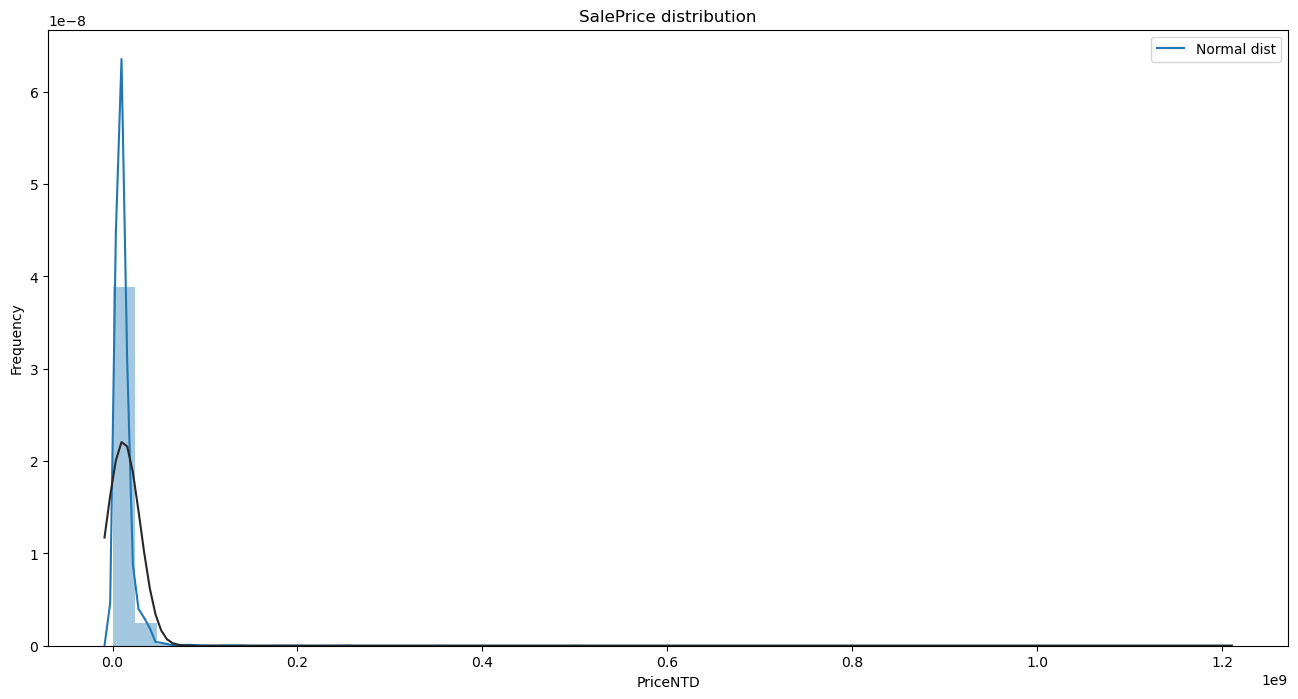

In [11]:

# 绘制目标特征的概率分布图
plt.figure(figsize=(16, 8))
sns.distplot(train_data['PriceNTD'], fit=norm) # 拟合标准正态分布
plt.legend(['Normal dist'], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# 获取目标特征的正态分布参数
(mu, sigma) = norm.fit(train_data['PriceNTD']) # fit方法：对一组随机取样进行拟合，最大似然估计方法找出最适合取样数据的概率密度函数系数。
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

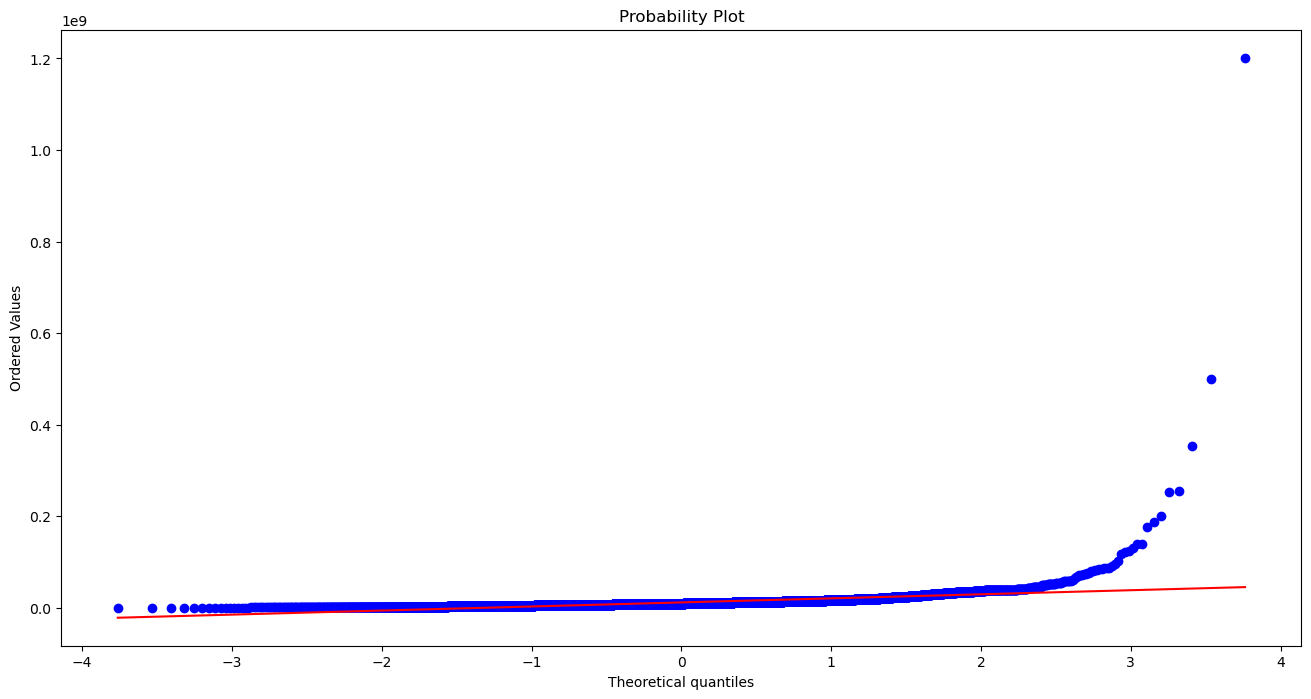

In [12]:
plt.figure(figsize=(16, 8))
res = stats.probplot(train_data['PriceNTD'], plot=plt)


 mu = 16.00 and sigma = 0.72



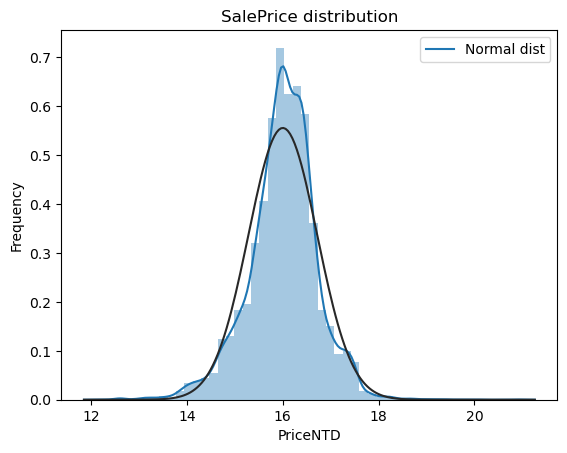

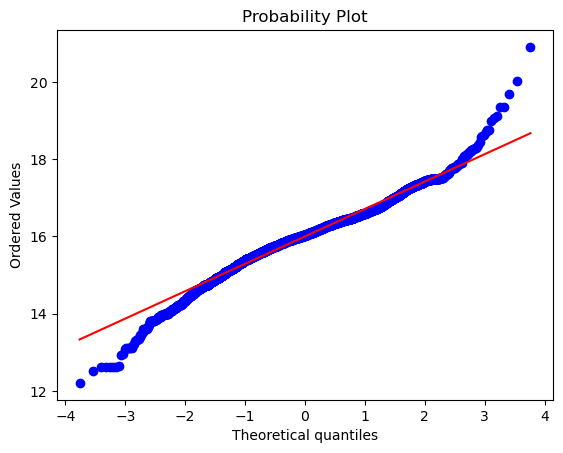

In [13]:
# 正态化Y
train_data['PriceNTD']= np.log1p(train_data['PriceNTD'])

# 绘制分布图检查新的分布
sns.distplot(train_data['PriceNTD'], fit=norm);
plt.legend(['Normal dist'], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# 获取新的正态分布参数
(mu, sigma) = norm.fit(train_data['PriceNTD'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# 绘制QQ-plot图
fig = plt.figure()
res = stats.probplot(train_data['PriceNTD'], plot=plt)

In [14]:
train_data = train_data.drop(['Land','theUseZoningorCompiles','TransactionYearMonthDay','ManagementOrganization','elevator','BerthCategory','Year'], axis=1)

In [15]:
X = train_data[['District', 'LandShiftingTotalArea','ShiftingfloorNumber', 'floor',
       'BuildingState', 'ConstructionYear', 'BuildingShiftingTotalArea',
       'Room', 'Hall', 'Bathroom', 'Compartment','BerthShiftingTotalArea',
       'BerthTotalPriceNTD', 'main building area', 'auxiliary building area',
       'balcony area','Building', 'Berth']]
y = train_data['PriceNTD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# 開始

In [53]:
from lightgbm import LGBMRegressor
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
study = optuna.create_study(
        storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
        study_name="quadratic-simple"
    )
def objective(trial):
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20, 50]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),      
        'early_stopping_rounds' : 100,
        'verbose': -1,
    }
    
    lgb=LGBMRegressor(**param)
    lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    pred_lgb=lgb.predict(X_test)
    rmse = mean_squared_error(y_test, pred_lgb, squared=False)
    return rmse


[I 2024-05-21 12:51:29,885] A new study created in RDB with name: quadratic-simple


In [54]:
study=optuna.create_study(direction='minimize')
n_trials=50 # try50次
study.optimize(objective, n_trials=n_trials)

[I 2024-05-21 12:51:31,866] A new study created in memory with name: no-name-fe23effc-ac95-457b-9236-a467f3ce3b7b
[I 2024-05-21 12:51:33,490] Trial 0 finished with value: 0.2566583691592317 and parameters: {'reg_alpha': 0.2947274852059086, 'reg_lambda': 2.0328577663059115, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 5, 'num_leaves': 766, 'min_child_samples': 134, 'cat_smooth': 77}. Best is trial 0 with value: 0.2566583691592317.
[I 2024-05-21 12:51:34,352] Trial 1 finished with value: 0.2554808594306103 and parameters: {'reg_alpha': 0.0499679585345907, 'reg_lambda': 0.023037226901972276, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 84, 'min_child_samples': 26, 'cat_smooth': 61}. Best is trial 1 with value: 0.2554808594306103.
[I 2024-05-21 12:51:35,463] Trial 2 finished with value: 0.2576347304369364 and parameters: {'reg_alpha': 0.001176307170599685, 'reg_lambda': 0.0011606723359360396, 'colsample

In [18]:
optuna.visualization.plot_optimization_history(study)# 繪製圖表

In [19]:
optuna.visualization.plot_parallel_coordinate(study)# 


In [20]:
optuna.visualization.plot_param_importances(study)# 


In [52]:
optuna.visualization.plot_optimization_history(study)


In [21]:
params=study.best_params
params['metric'] = 'rmse'

In [23]:
params

{'reg_alpha': 0.3168174362508883,
 'reg_lambda': 0.016143046521524384,
 'colsample_bytree': 0.5,
 'subsample': 0.8,
 'learning_rate': 0.014,
 'max_depth': 5,
 'num_leaves': 610,
 'min_child_samples': 1,
 'cat_smooth': 60,
 'metric': 'rmse'}